# **Exercise 4 - Group 08 (Academic Year 2022-2023)**
 
- Erica Brisigotti (2097202)
- Ekaterina Chueva (2072050)
- Sofia Pacheco Garcia (2070771)
- Nadillia Sahputra (2070770)

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance, to_graphviz, plot_tree
from sklearn.utils import shuffle 
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.model_selection import GridSearchCV
import tensorflow.random as tf_r
from scikeras.wrappers import KerasClassifier
plt.rcParams['font.size'] = 14

First of all, we generate/upload the data: we generate a lot of it since we are going to need it later.

In [2]:
np.random.seed(123)

S = 2
N = 20000
N_train = int(N/2)
N_test = int(N/2)
x = S*(2*np.random.rand(N,2)-1)
y = np.zeros(N).astype(int)
z = 2*x+0.5
e = 2*x-0.5
a = -0.5*x+0.2
b = -0.5*x-0.1

for n in range(N):
    if x[n,1]<-0.6 and x[n,0]>-0.2: y[n]=1
    if x[n,1]>0.4 and x[n,0]<-0.8: y[n]=1
    if x[n,1]>1.0 and x[n,0]>0.8: y[n]=1
    if x[n,1]<z[n,0] and x[n,1]>e[n,0]: y[n]=1
    if x[n,1]<a[n,0] and x[n,1]>b[n,0]: y[n]=1
            

For the first two sections of the analysis, we look for the best combination of parameters for the DNN and XGBoost: to achive this goal, we choose an intermediate size of the dataset to be analysed and implement a GridSearch.

In [3]:
i_i = 2000 
X_i,Y_i = shuffle(x,y)
X_i = X_i[:i_i]
Y_i = Y_i[:i_i]

N_train = int(i_i/2)
N_test  = i_i - N_train 

x_train,y_train = X_i[:N_train],Y_i[:N_train]
x_test,y_test = X_i[(N_train-1):],Y_i[(N_train-1):]
L=len(x_train[0])

We then define a custom function for plotting:

In [4]:
def scat(x,y,s=4,cmap="plasma"):
    plt.scatter(x[:,0],x[:,1],s=s,c=y,cmap=cmap)
    plt.xlabel("feature 0")
    plt.ylabel("feature 1")

We use said function to represent the generated data (which is already been split into the training and testing datatsets) by color-coding it based on the labels.

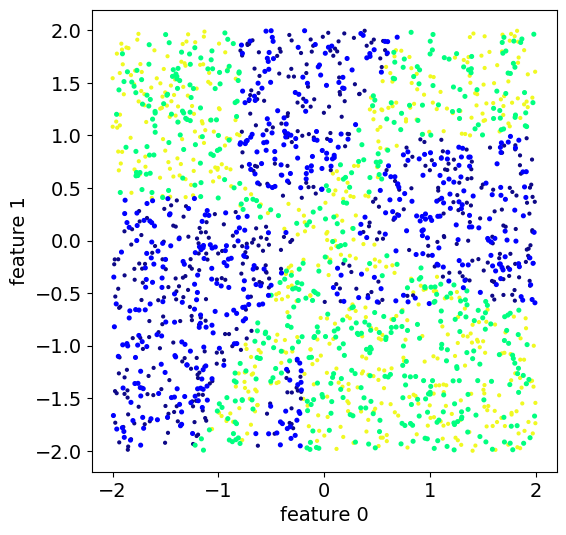

In [5]:
plt.figure(figsize=(6,6))
scat(x_train,y_train)
scat(x_test,y_test,cmap="winter",s=7)
plt.show()

We then define a function to summarize the classification process, which can both display the trees used in the classification process (when <code>trees=True</code>) and generate data to be classified to represent the results of the ML algorithm  (when <code>show=True</code>):

In [6]:
def classify(clf=GradientBoostingClassifier(),show=False, boost = True, trees = False):
    # boost = True if use XGboost and false if Neural Network
    if boost:
        clf.fit(x_train,y_train, verbose=0)
        acc=clf.score(x_test, y_test)    
    else:
        fit_dnn  = clf.fit(x_train, y_train, epochs = 200, batch_size = 50, validation_data=(x_test,y_test), verbose=0)
        y_hat = clf.predict(x_test)
        acc = (fit_dnn.history['accuracy'])[-1]     

    if show:
        dx = 0.02
        x_seq=np.arange(-S,S+dx,dx)
        nx = len(x_seq)
        x_plot=np.zeros((nx*nx,2))
        q=0
        for i in range(nx):
            for j in range(nx):
                x_plot[q,:] = [x_seq[i],x_seq[j]]
                q+=1    
        y_plot= clf.predict(x_plot)
#         plt.figure(figsize=(6,6))
#         plt.title(str(clf))
#         scat(x_plot,y_plot,cmap="winter",s=1)
#         scat(x_train,y_train,s=7)
#         plt.show()
    
    if boost:
        if trees:      
            dump_list = clf.get_booster().get_dump()
            num_trees = len(dump_list)
            print("num_trees=",num_trees)

            fig, AX = plt.subplots(3,1,figsize=(30, 30))
            for i in range(min(3,num_trees)):
                ax=AX[i]
                plot_tree(clf, num_trees=i, ax=ax)
            fig.savefig("DATA/tree-classif.png", dpi=300, pad_inches=0.02)   
            plt.show()
    return acc, x_plot,y_plot

## 1. Gridsearch for DNN


First of all, we define the DNN model:

In [7]:
def create_model(optimizer='sgd', activation ='elu', neurons = 20):
    model = Sequential()
    model.add(Dense(L,input_shape=(L,), activation=activation))
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(neurons, activation=activation))
    model.add(Dropout(0.01))
    model.add(Dense(1,activation='sigmoid'))
    nepoch=200
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

Before comparing the DNN to other methods, we find the the combination of parameters for the DNN that performs best (with highest accuracy) for this dataset: we do this via GridSearch for an intermediate size of the input (of 2000 points):

In [8]:
np.random.seed(2072050)
import tensorflow.random as tf_r
tf_r.set_seed(2072050)

# create model
model = KerasClassifier(model=create_model, epochs=200, batch_size=50, verbose=0)

# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adam']
activation = [ 'sigmoid','relu','elu']
neurons = [10,15,20]
param_grid = dict(model__optimizer=optimizer, model__activation = activation, model__neurons = neurons)

# actual gridsearch
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train)

# saving info about gridsearch results in a dataframe in descending order of accuracy
results_DNN = pd.concat([pd.DataFrame(grid.cv_results_["params"]),
                     pd.DataFrame(grid.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
results_DNN = results_DNN.sort_values(by=['Accuracy'], ascending = False)
results_DNN = results_DNN.reset_index(drop=True)
print("the best performing combinations of parameters for DNN (from highest to lowest accuracy): ")
results_DNN.head()

the best performing combinations of parameters for DNN (from highest to lowest accuracy): 


,model__activation,model__neurons,model__optimizer,Accuracy
0,elu,20,Adam,0.899019
1,elu,15,Adam,0.867110
2,elu,15,RMSprop,0.846961
3,relu,15,Adam,0.842049
4,elu,10,RMSprop,0.826944


In [9]:
print('the optimal activation function for DNN is: ',results_DNN['model__activation'][0])
print('the optimal number of neurons for DNN hidden layer is: ',results_DNN['model__neurons'][0])
print('the optimal optimizer for DNN is: ',results_DNN['model__optimizer'][0])

the optimal activation function for DNN is:  elu
the optimal number of neurons for DNN hidden layer is:  20
the optimal optimizer for DNN is:  Adam


## 2. GridSearch for XGBoost
Try different parameters (λ, γ, n_estimators, ...). Which is the simplest yet effective XGBoost model that keeps a good accuracy?

In [10]:
# create model
estimator = XGBClassifier( objective= 'binary:logistic', nthread=4, seed=42)

# define the grid search parameters
parameters = { 'reg_lambda': [1, 10,50], 
              'gamma': [0,0.01,0.1,0.2,0.5],
              'n_estimators': range(60, 220, 40)  }

# actual gridsearch
grid_search = GridSearchCV(estimator=estimator, param_grid=parameters, scoring = 'roc_auc', n_jobs = 10,cv = 10,verbose=2)
grid_result = grid_search.fit(x_train, y_train)

# saving info about gridsearch results in a dataframe in descending order of accuracy
results = pd.concat([pd.DataFrame(grid_search.cv_results_["params"]),
                     pd.DataFrame(grid_search.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
results_xgb = results.sort_values(by=['Accuracy'], ascending = False)
results_xgb = results_xgb.reset_index(drop=True)
print("the best performing combinations of parameters are (from highest to lowest accuracy): ")
(results_xgb).head()

Fitting 10 folds for each of 60 candidates, totalling 600 fits
the best performing combinations of parameters are (from highest to lowest accuracy): 


,gamma,n_estimators,reg_lambda,Accuracy
0,0.20,180,1,0.983707
1,0.10,180,1,0.982477
2,0.00,180,1,0.982294
3,0.01,180,1,0.982052
4,0.10,140,1,0.980601


In [11]:
print('the optimal number of estimators is: ',results_xgb['n_estimators'][0])
print('the optimal value of parameter lambda is: ',results_xgb['reg_lambda'][0])
print('the optimal value of parameter gamma is: ',results_xgb['gamma'][0])

the optimal number of estimators is:  180
the optimal value of parameter lambda is:  1
the optimal value of parameter gamma is:  0.2


## 3. DNN VS XGBOOST for classification

Compare the performances of XGBoost with those of a feed-forward neural network (NN). Take a labeled dataset (two categories) that is simple enough for analysis in a reasonable time. As usual, separate the training and the test set. Compare the accuracy of the two methods by varying the number of data samples in the training set

We now compare the performance of the classification done by DNN vs XGBoost algorithms, both with their respective optimal parameters: we evaluate such performance for different sizes of the analyzed dataset.

1263/1263 [==============================] - 1s 589us/step


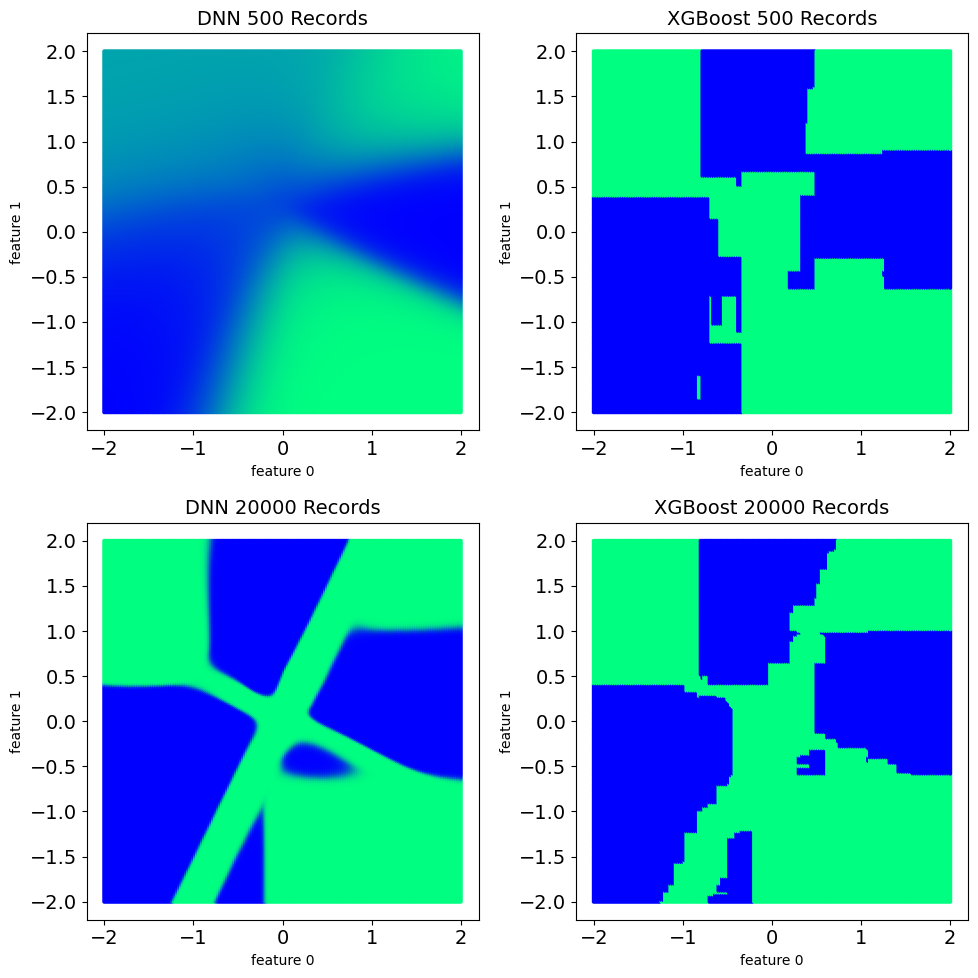

In [12]:
size = np.array([500,1000,5000,10000,20000])
acc_DNN = np.zeros(5)
acc_XGBC = np.zeros(5)
fig,ax = plt.subplots(2,2, figsize = (10,10))

for idx,i in enumerate(size):
    x_plot_DNN,y_plot_DNN = 0,0
    x_plot_XGB,y_plot_XGB = 0,0
    
    X,Y = shuffle(x,y)
    X = X[:i-1]
    Y = Y[:i-1]

    N_train = int(i/2)
    N_test  = i - N_train 
    
    x_train,y_train = X[:N_train],Y[:N_train]
    x_test,y_test = X[(N_train-1):],Y[(N_train-1):]
    L=len(x_train[0])
    model = create_model(optimizer= results_DNN['model__optimizer'][0], activation = results_DNN['model__activation'][0], 
                         neurons=results_DNN['model__neurons'][0]) 
        
    temp_1,x_plot_DNN,y_plot_DNN=classify(clf=model, boost=False, show = True)
    temp_2,x_plot_XGB,y_plot_XGB = classify(XGBClassifier(seed=1, objective='binary:logistic',
                       reg_lambda = results_xgb['reg_lambda'][0], 
                       n_estimators = results_xgb['n_estimators'][0],
                       gamma = results_xgb['gamma'][0] ), show=True)
    acc_DNN[idx]=temp_1
    acc_XGBC[idx]=temp_2
    
    if (idx == 0):
        ax[0][0].scatter(x_plot_DNN[:,0],x_plot_DNN[:,1],s=4,c=y_plot_DNN,cmap="winter")
        ax[0][1].scatter(x_plot_XGB[:,0],x_plot_XGB[:,1],s=4,c=y_plot_XGB,cmap="winter")
        ax[0][0].set_title("DNN 500 Records", size = 14)
        ax[0][1].set_title("XGBoost 500 Records", size = 14)
        ax[0][0].set_xlabel("feature 0", size = 10)
        ax[0][0].set_ylabel("feature 1", size = 10)
        ax[0][1].set_xlabel("feature 0", size = 10)
        ax[0][1].set_ylabel("feature 1", size = 10)
        
    elif (idx == (len(size)-1)):
        ax[1][0].scatter(x_plot_DNN[:,0],x_plot_DNN[:,1],s=4,c=y_plot_DNN,cmap="winter")
        ax[1][1].scatter(x_plot_XGB[:,0],x_plot_XGB[:,1],s=4,c=y_plot_XGB,cmap="winter")
        ax[1][0].set_title("DNN 20000 Records", size = 14)
        ax[1][1].set_title("XGBoost 20000 Records", size = 14)
        ax[1][0].set_xlabel("feature 0",size = 10)
        ax[1][0].set_ylabel("feature 1",size = 10)
        ax[1][1].set_xlabel("feature 0",size = 10)
        ax[1][1].set_ylabel("feature 1",size = 10)
    plt.tight_layout()

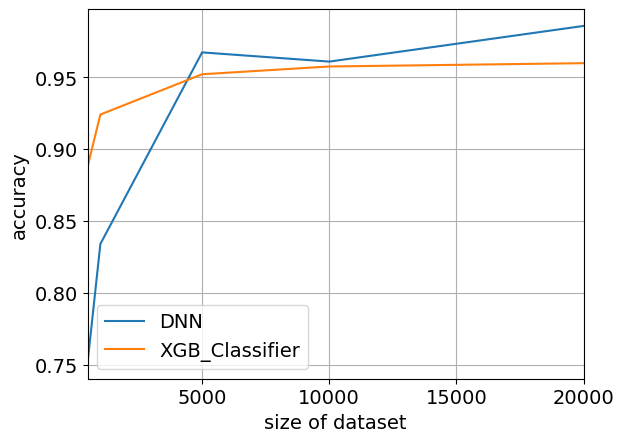

In [13]:
size = np.array([500,1000,5000,10000,20000])
fig, ax= plt.subplots()
ax.plot(size, acc_DNN, label='DNN')
ax.plot(size, acc_XGBC, label='XGB_Classifier')
ax.set_xlabel('size of dataset')
ax.set_ylabel('accuracy')
ax.set_xlim(np.min(size),np.max(size))
ax.locator_params(axis='x', nbins=5)
ax.grid()
ax.legend()

## 4. Conclusion
The following results are spesific to the dataset generated above with additional 2 diagonal lines.
From the graph above, we see that the two classifiers compete for the best accuracy. 
The most accurate classification algorithm is:
- XGB for moderate dimensions of the dataset (< 10000 aprox) 
- DNN for higher dimensions of the dataset (>10000 aprox)
